In [1]:
import os
import time
import datetime
import json
import re
import copy
import asyncio
import h5py
from scipy.sparse import csr_matrix, lil_matrix, eye, csgraph
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.sparse
import matplotlib.pyplot as plt
import quadprog
from muskingum import MuskingumCunge, KalmanFilter, ExpectationMaximization, ExpectationMaximizationIO, AsyncSimulation, ModelCollection
from muskingum import _ax, _ax_bu, _apply_gain
from muskingum import numba_init_inflows, numba_matmat, numba_matmat_par
from numba import njit
import geopandas as gpd
import matplotlib as mpl
from calibration_util import solve_parameters, nse, kge, load_data
from sklearn.metrics import r2_score

In [2]:
basepath = '/Users/jeiloh/Desktop/forecasting_overtopping/guadalupe/data'
nwm_export = 'export_Guadalupe_2023'
date_list = pd.date_range('20230401', '20230701', freq='h', tz='utc')

all_inputs, all_streamflows = load_data(basepath, nwm_export, date_list)

with open(f'{basepath}/gua_together_cleaned.json') as texas:
    d = json.load(texas)

In [6]:
link_ids = [i['attributes']['COMID'] for i in d['features']]
reach_ids = link_ids
reach_ids = [str(x) for x in reach_ids]

In [4]:
mc = MuskingumCunge(d, create_state_space=False, sparse=True, verbose=False)
mc.K[:] = np.maximum(mc.dx / 2.12, 3600.)
mc.X[:] = 0.25
mc.compute_muskingum_coeffs()

p_t = all_inputs
p_t.columns = p_t.columns.astype(str)
p_t = p_t[mc.reach_ids]
p_t = p_t.astype(float)
streamflow = all_streamflows
streamflow.columns = streamflow.columns.astype(str)
streamflow = streamflow[mc.reach_ids]
streamflow = streamflow.astype(float)

mc.datetime = p_t.index[0] - pd.to_timedelta('1h')
mc.save_state()

In [7]:
mc.init_states(o_t_next=streamflow.iloc[0][mc.reach_ids].fillna(0.).values)
index = reach_ids.index('1643861')
ix = [index]

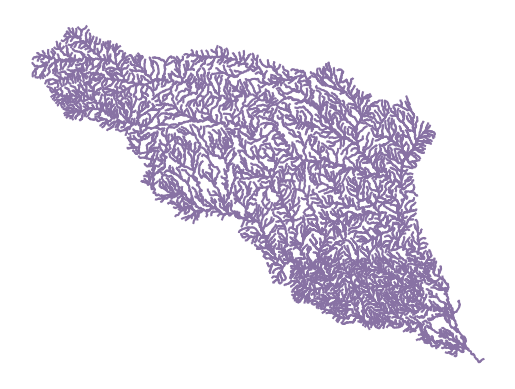

In [8]:
model_collection = mc.split(ix, p_t[:-1], create_state_space=False)
model_collection_1 = mc.split(ix, p_t[:-1], create_state_space=False)
model_collection.save_states()
model_collection_1.save_states()

fig, ax = plt.subplots()
for index, model in model_collection.models.items():
    c = f'#{np.random.randint(0, 0xFFFFFF):06x}'
    model.plot(ax=ax, c=c)
    plt.axis('off')

In [7]:
model = model_collection_1.models[0]
inputs = model_collection_1.inputs[0]

model.init_states(o_t_next=streamflow.iloc[0][model.reach_ids].fillna(0.).values)
model.datetime = inputs.index[0] - pd.to_timedelta('1h')

i_t = []
o_t = []
datetimes = []
for state in model.simulate_iter(inputs):
    datetime = state.datetime
    i_t_next = state.i_t_next.copy()
    o_t_next = state.o_t_next.copy()
    i_t.append(i_t_next)
    o_t.append(o_t_next)
    datetimes.append(datetime)
i_t = np.vstack(i_t)
o_t = np.vstack(o_t)

In [8]:
o_t_nwm = streamflow[model.reach_ids][:-1]

i_t_recon = []
for o_t_next in o_t_nwm.values:
    i_t_next = np.zeros(model.n)
    no_selfloops = model.startnodes != model.endnodes
    np.add.at(i_t_next, model.endnodes[no_selfloops], o_t_next[model.startnodes][no_selfloops])
    i_t_recon.append(i_t_next)
i_t_recon = np.vstack(i_t_recon)

In [9]:
K, X = solve_parameters(model, i_t_recon, o_t_nwm.values, inputs, datetimes)

In [10]:
model.init_states(o_t_next=streamflow.iloc[0][model.reach_ids].fillna(0.).values)
model.datetime = inputs.index[0] - pd.to_timedelta('1h')
model.K[:] = K
model.X[:] = X
model.compute_muskingum_coeffs()

i_t = []
o_t = []
datetimes = []
for state in model.simulate_iter(inputs):
    datetime = state.datetime
    i_t_next = state.i_t_next.copy()
    o_t_next = state.o_t_next.copy()
    i_t.append(i_t_next)
    o_t.append(o_t_next)
    datetimes.append(datetime)
i_t = np.vstack(i_t)
o_t = np.vstack(o_t)

o_t_df = pd.DataFrame(o_t)
o_t_df.columns = inputs.columns

In [11]:
GAUGES_USGS = {
    # san antonio
    "10840818":'USGS-08178050',
    "10840824":'USGS-08178500',
    "10840502":'USGS-08178565',
    "10840230":'USGS-08178593',
    "10840232":'USGS-08178700',
    "10840488":'USGS-08178800',
    "10834470":'USGS-0817887350', 
    "10833740":'USGS-08178880',
    "10834916":'USGS-08178980', 
    "10835018":'USGS-08180586', 
    "10836382":'USGS-08180640', 
    "10835982":'USGS-08180700',
    "10836104":'USGS-08180800', 
    "10835030":'USGS-08181400', 
    "10836388":'USGS-08181480',
    "10836092":'USGS-08181500', 
    "10840558":'USGS-08181725',
    "10840572":'USGS-08181800',
    "3836053":'USGS-08183200',
    "3838221":'USGS-08183500', 
    "7850579":'USGS-08183900', 
    "7850611":'USGS-08183978', 
    "7850687":'USGS-08185065', 
    "7851629":'USGS-08185100', 
    "7851771":'USGS-08185500',
    "7852265":'USGS-08186000',
    "3838999":'USGS-08186500',
    "3839263":'USGS-08187500',
    "3839167":'USGS-08188060', 
    "3840125":'USGS-08188500',
    "3840137":'USGS-08188570',
    #Guadalupe
    "3585678":"USGS-08165300",
    "3585620":"USGS-08165500",
    "3585554":"USGS-08166000",
    "3585626":"USGS-08166140",
    "3585724":"USGS-08166200",
    "3587616":"USGS-08166250",
    "3589508":"USGS-08167000",
    "3589062":"USGS-08167200",
    "3589120":"USGS-08167500",
    "1619595":"USGS-08167800",
    "1619637":"USGS-08168000",
    "1620031":"USGS-08168500",
    "1619663":"USGS-08168797",
    "1619647":"USGS-08168932", 
    "1619649":"USGS-08169000",
    "1620877":"USGS-08169792",
    "1622735":"USGS-08169845",
    "1631099":"USGS-08170500",
    "1628253":"USGS-08170950",
    "1628219":"USGS-08170990",
    "1630223":"USGS-08171000",
    "1629555":"USGS-08171290",
    "1631129":"USGS-08171350",
    "1631195":"USGS-08171400",
    "1631387":"USGS-08172000",
    "1631087":"USGS-08172400",
    "1631587":"USGS-08173000",
    "1622713":"USGS-08173900", 
    "1620735":"USGS-08174200",
    "1620703":"USGS-08174550",
    "1622763":"USGS-08174600",
    "1623075":"USGS-08174700",
    "1623207":"USGS-08175000",
    "1637437":"USGS-08175800",
    "1639225":"USGS-08176500",
    "1638559":"USGS-08176900",
    "1638907":"USGS-08177500",
}
gage_lists = list(GAUGES_USGS.keys())

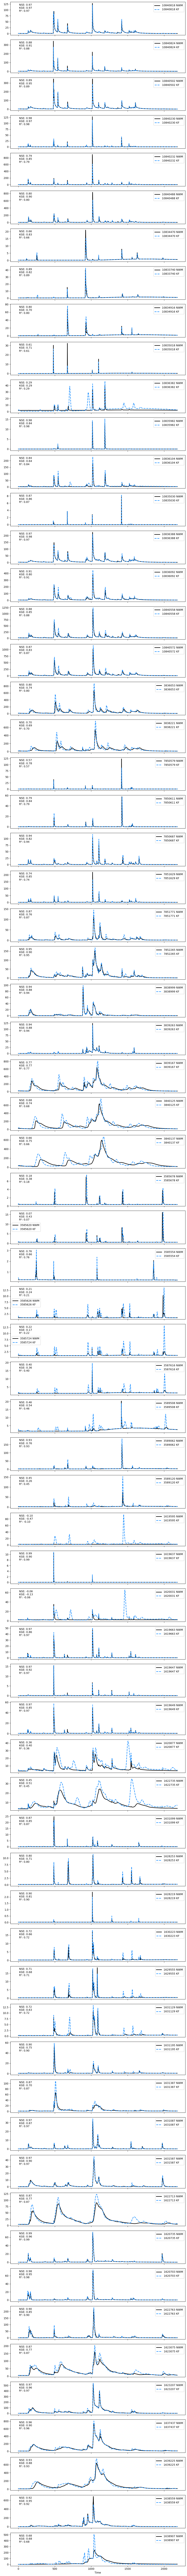

In [12]:
num_gages = len(gage_lists)

fig, axes = plt.subplots(num_gages, 1, figsize=(10, 2 * num_gages), sharex=True)
if num_gages == 1:
    gage = gage_lists[0]
    observed = o_t_df[gage].values
    modeled = o_t_nwm[gage].values
    
    axes.plot(modeled, label=f'{gage} NWM', linestyle='--', color='black', linewidth=2)
    axes.plot(observed, label=f'{gage} KF', linestyle='-', color='dodgerblue', linewidth=2)
    
    nse_val = nse(observed, modeled)
    kge_val = kge(observed, modeled)
    r2_val = r2_score(observed, modeled)
    
    axes.text(0.05, 0.95, f'NSE: {nse_val:.2f}\nKGE: {kge_val:.2f}\nR²: {r2_val:.2f}',
              transform=axes.transAxes, verticalalignment='top')
    
    axes.legend()
else:
    for i, gage in enumerate(gage_lists):
        observed = o_t_df[gage].values
        modeled = o_t_nwm[gage].values
        
        axes[i].plot(modeled, label=f'{gage} NWM', linestyle='-', color='black', linewidth=2)
        axes[i].plot(observed, label=f'{gage} KF', linestyle='--', color='dodgerblue', linewidth=2)
        
        nse_val = nse(observed, modeled)
        kge_val = kge(observed, modeled)
        r2_val = r2_score(observed, modeled)
        
        axes[i].text(0.05, 0.95, f'NSE: {nse_val:.2f}\nKGE: {kge_val:.2f}\nR²: {r2_val:.2f}',
                     transform=axes[i].transAxes, verticalalignment='top')
        
        axes[i].legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()